## Import Modules

In [ ]:
!pip install -U gdown

### General Modules & Libraries

In [ ]:
import matplotlib.pyplot as plt
import zipfile
import gdown
from pathlib import Path
import os
import random
from skimage import io, img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.transform import AffineTransform, warp
import numpy as np
import cv2
import shutil

### Modules & Libraries for Deep Learning Modelling

In [ ]:
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras import Model, layers, models
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from IPython.display import display
from keras.layers import TFSMLayer
from tensorflow.keras.applications import ResNet50

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

## Import/Load Kaggle Dataset

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"yonathantirza","key":"e585ad65bb27a63c1ec537a6a922d854"}'}

In [ ]:
!ls -lha kaggle.json

-rw-r--r-- 1 root root 69 May 24 13:32 kaggle.json


In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!pwd

/content


In [ ]:
!kaggle datasets download -d t2obd1a1253kmit/clean-augmented-anemia-dataset

Dataset URL: https://www.kaggle.com/datasets/t2obd1a1253kmit/clean-augmented-anemia-dataset
License(s): CC-BY-SA-3.0
 96% 880M/919M [00:07<00:00, 42.1MB/s]
100% 919M/919M [00:07<00:00, 128MB/s] 


In [ ]:
!unzip clean-augmented-anemia-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: New_Augmented_Anemia_Dataset/Palm/Training/Non-Anemic/Non-AnemicP-006_aug6.png  
  inflating: New_Augmented_Anemia_Dataset/Palm/Training/Non-Anemic/Non-AnemicP-006_aug7.png  
  inflating: New_Augmented_Anemia_Dataset/Palm/Training/Non-Anemic/Non-AnemicP-006_aug8.png  
  inflating: New_Augmented_Anemia_Dataset/Palm/Training/Non-Anemic/Non-AnemicP-006_aug9.png  
  inflating: New_Augmented_Anemia_Dataset/Palm/Training/Non-Anemic/Non-AnemicP-007_aug1.png  
  inflating: New_Augmented_Anemia_Dataset/Palm/Training/Non-Anemic/Non-AnemicP-007_aug11.png  
  inflating: New_Augmented_Anemia_Dataset/Palm/Training/Non-Anemic/Non-AnemicP-007_aug13.png  
  inflating: New_Augmented_Anemia_Dataset/Palm/Training/Non-Anemic/Non-AnemicP-007_aug14.png  
  inflating: New_Augmented_Anemia_Dataset/Palm/Training/Non-Anemic/Non-AnemicP-007_aug16.png  
  inflating: New_Augmented_Anemia_Dataset/Palm/Training/Non-Anemic/Non-AnemicP-007_aug17.png  
  in

## Explore the Data

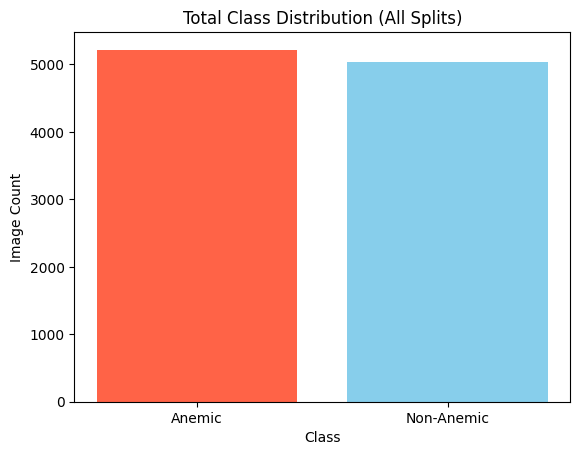

In [ ]:
base_path = Path("/content/New_Augmented_Anemia_Dataset/Conjuctiva")

def plot_all_data():
  class_counts = {"Anemic": 0, "Non-Anemic": 0}

  for split in ["Training", "Validation", "Testing"]:
      for cls in class_counts:
          dir_path = os.path.join(base_path, split, cls)
          if os.path.exists(dir_path):
              class_counts[cls] += len(os.listdir(dir_path))

  # Plot
  plt.bar(class_counts.keys(), class_counts.values(), color=["tomato", "skyblue"])
  plt.title("Total Class Distribution (All Splits)")
  plt.xlabel("Class")
  plt.ylabel("Image Count")
  plt.show()

plot_all_data()

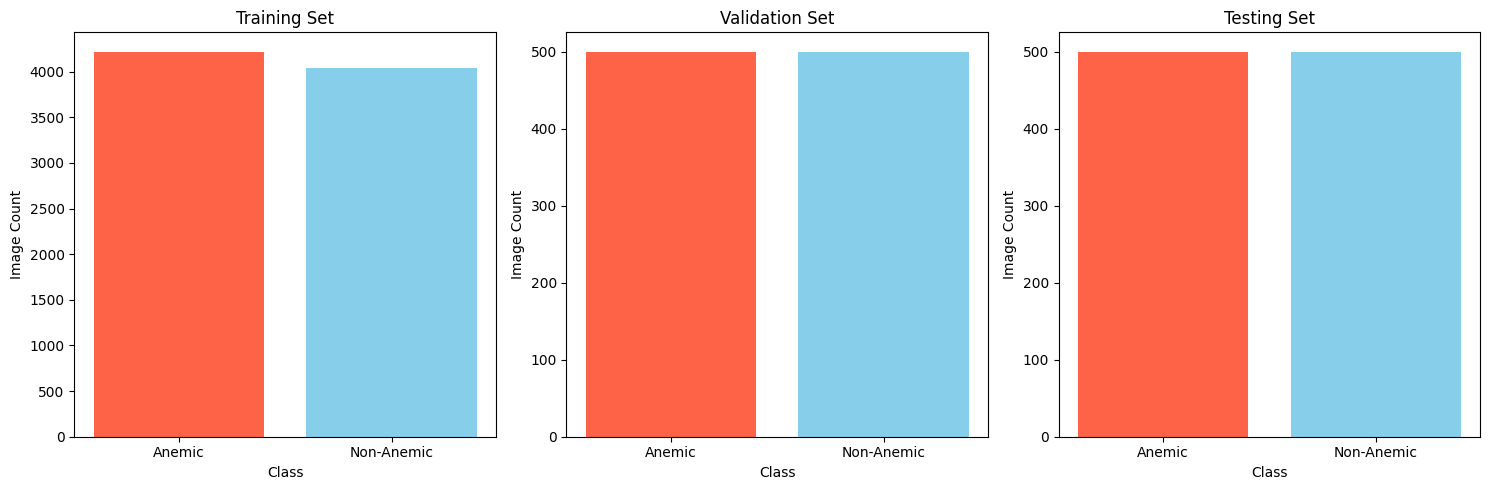

In [ ]:
def plot_each_set():
    split_counts = {"Training": {}, "Validation": {}, "Testing": {}}

    for split in split_counts:
        for cls in ["Anemic", "Non-Anemic"]:
            dir_path = os.path.join(base_path, split, cls)
            split_counts[split][cls] = len(os.listdir(dir_path)) if os.path.exists(dir_path) else 0

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    for idx, split in enumerate(["Training", "Validation", "Testing"]):
        counts = split_counts[split]
        axs[idx].bar(counts.keys(), counts.values(), color=["tomato", "skyblue"])
        axs[idx].set_title(f"{split.capitalize()} Set")
        axs[idx].set_xlabel("Class")
        axs[idx].set_ylabel("Image Count")

    plt.tight_layout()
    plt.show()

plot_each_set()

## Modelling Using Pretrained and/or Transfer Learning

In [ ]:
train_dir = base_path / "Training"
val_dir = base_path / "Validation"
test_dir = base_path / "Testing"

img_height, img_width = 224, 224
batch_size = 128

train_datagen = ImageDataGenerator(rescale=1./255)

val_datagen   = ImageDataGenerator(rescale=1./255)

test_datagen  = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    directory=val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 8256 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.Dropout(0.2),
    layers.Dense(train_generator.num_classes, activation='sigmoid')
])

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,718,978 (90.48 MB)

 Trainable params: 131,266 (512.76 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
checkpoint = ModelCheckpoint(
    'best_fine_tuned_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=2,
    save_weights_only=False
)

In [ ]:
history = model.fit(train_generator,
                                      epochs=10,
                                      validation_data=val_generator,
                                      callbacks=[reduce_lr, checkpoint])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 562ms/step - accuracy: 0.5120 - loss: 0.8645
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to best_fine_tuned_model.keras
65/65 ━━━━━━━━━━━━━━━━━━━━ 72s 834ms/step - accuracy: 0.5119 - loss: 0.8640 - val_accuracy: 0.5000 - val_loss: 0.7837 - learning_rate: 1.0000e-04
Epoch 2/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - accuracy: 0.5029 - loss: 0.7842
Epoch 2: val_accuracy did not improve from 0.50000
65/65 ━━━━━━━━━━━━━━━━━━━━ 29s 447ms/step - accuracy: 0.5030 - loss: 0.7841 - val_accuracy: 0.5000 - val_loss: 0.7585 - learning_rate: 1.0000e-04
Epoch 3/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.5147 - loss: 0.7553
Epoch 3: val_accuracy did not improve from 0.50000
65/65 ━━━━━━━━━━━━━━━━━━━━ 28s 433ms/step - accuracy: 0.5145 - loss: 0.7552 - val_accuracy: 0.5000 - val_loss: 0.7408 - learning_rate: 1.0000e-04
Epoch 4/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.4950 - loss: 0.7401
Epoch 4: val_accura

In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc:.2f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 382ms/step - accuracy: 0.3587 - loss: 0.7069
Test accuracy: 0.52


## Model Evaluation

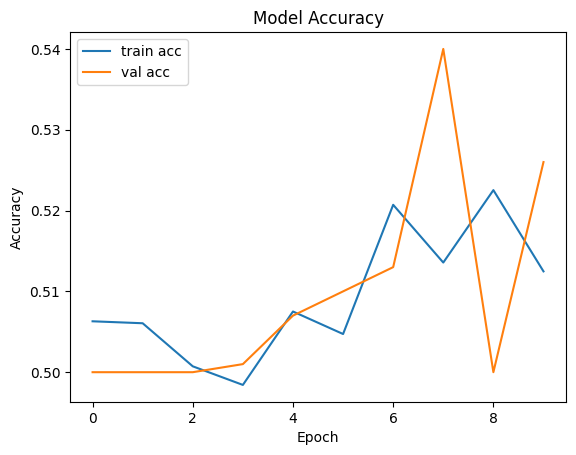

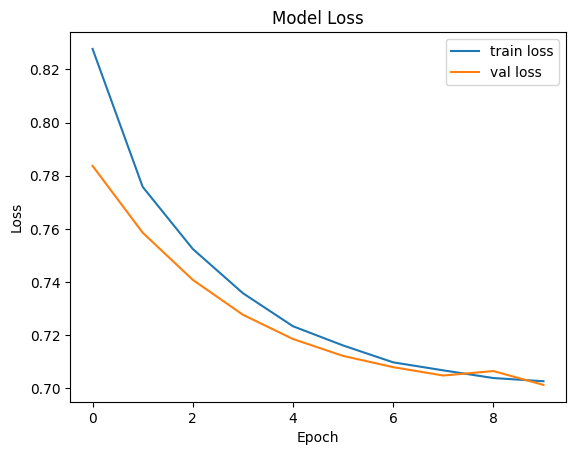

In [ ]:
def plot_model_acc(history):
    # Accuracy
    plt.plot(history.history['accuracy'], label='train acc')
    plt.plot(history.history['val_accuracy'], label='val acc')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Loss
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='val loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_model_acc(history)

In [ ]:
y_pred_probs = model.predict(test_generator)
y_pred = y_pred_probs.argmax(axis=1)

y_true = test_generator.classes

8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 945ms/step


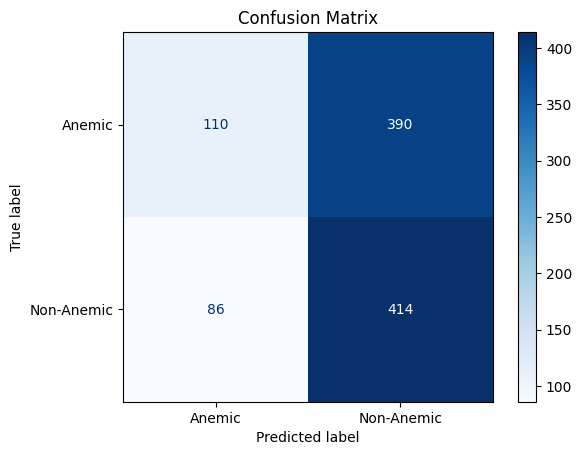

In [ ]:
class_names = ["Anemic", "Non-Anemic"]

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
base_model.trainable = True

for layer in base_model.layers[:-4]:
    layer.trainable = False

model.compile(
    optimizer=Adam(learning_rate=3e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
finetune_history = model.fit(train_generator,
                                      epochs=10,
                                      validation_data=val_generator,
                                      callbacks=[reduce_lr, checkpoint])

Epoch 1/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.5142 - loss: 0.7012
Epoch 1: val_accuracy improved from 0.54000 to 0.54100, saving model to best_fine_tuned_model.keras
65/65 ━━━━━━━━━━━━━━━━━━━━ 52s 606ms/step - accuracy: 0.5142 - loss: 0.7012 - val_accuracy: 0.5410 - val_loss: 0.6991 - learning_rate: 3.0000e-05
Epoch 2/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.5379 - loss: 0.6968
Epoch 2: val_accuracy did not improve from 0.54100
65/65 ━━━━━━━━━━━━━━━━━━━━ 28s 430ms/step - accuracy: 0.5377 - loss: 0.6968 - val_accuracy: 0.5200 - val_loss: 0.6981 - learning_rate: 3.0000e-05
Epoch 3/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.5431 - loss: 0.6954
Epoch 3: val_accuracy did not improve from 0.54100
65/65 ━━━━━━━━━━━━━━━━━━━━ 29s 438ms/step - accuracy: 0.5431 - loss: 0.6954 - val_accuracy: 0.5340 - val_loss: 0.6961 - learning_rate: 3.0000e-05
Epoch 4/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.5429 - loss: 0.6943
Epoch 4: val_acc

In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc:.2f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 364ms/step - accuracy: 0.5608 - loss: 0.6877
Test accuracy: 0.59


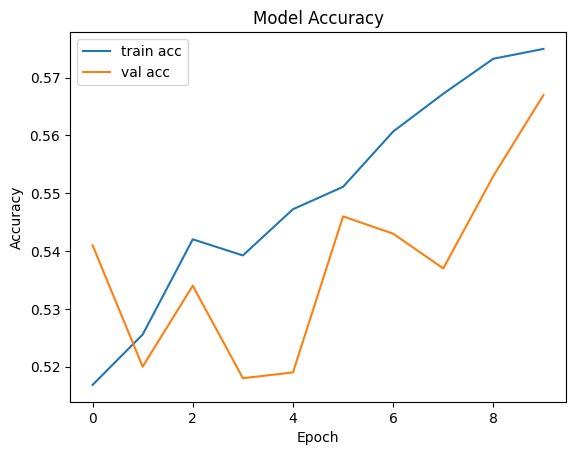

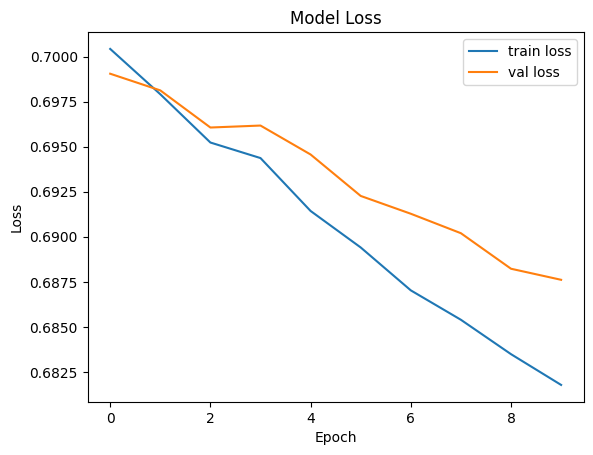

In [ ]:
plot_model_acc(finetune_history)

## Model Inference

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


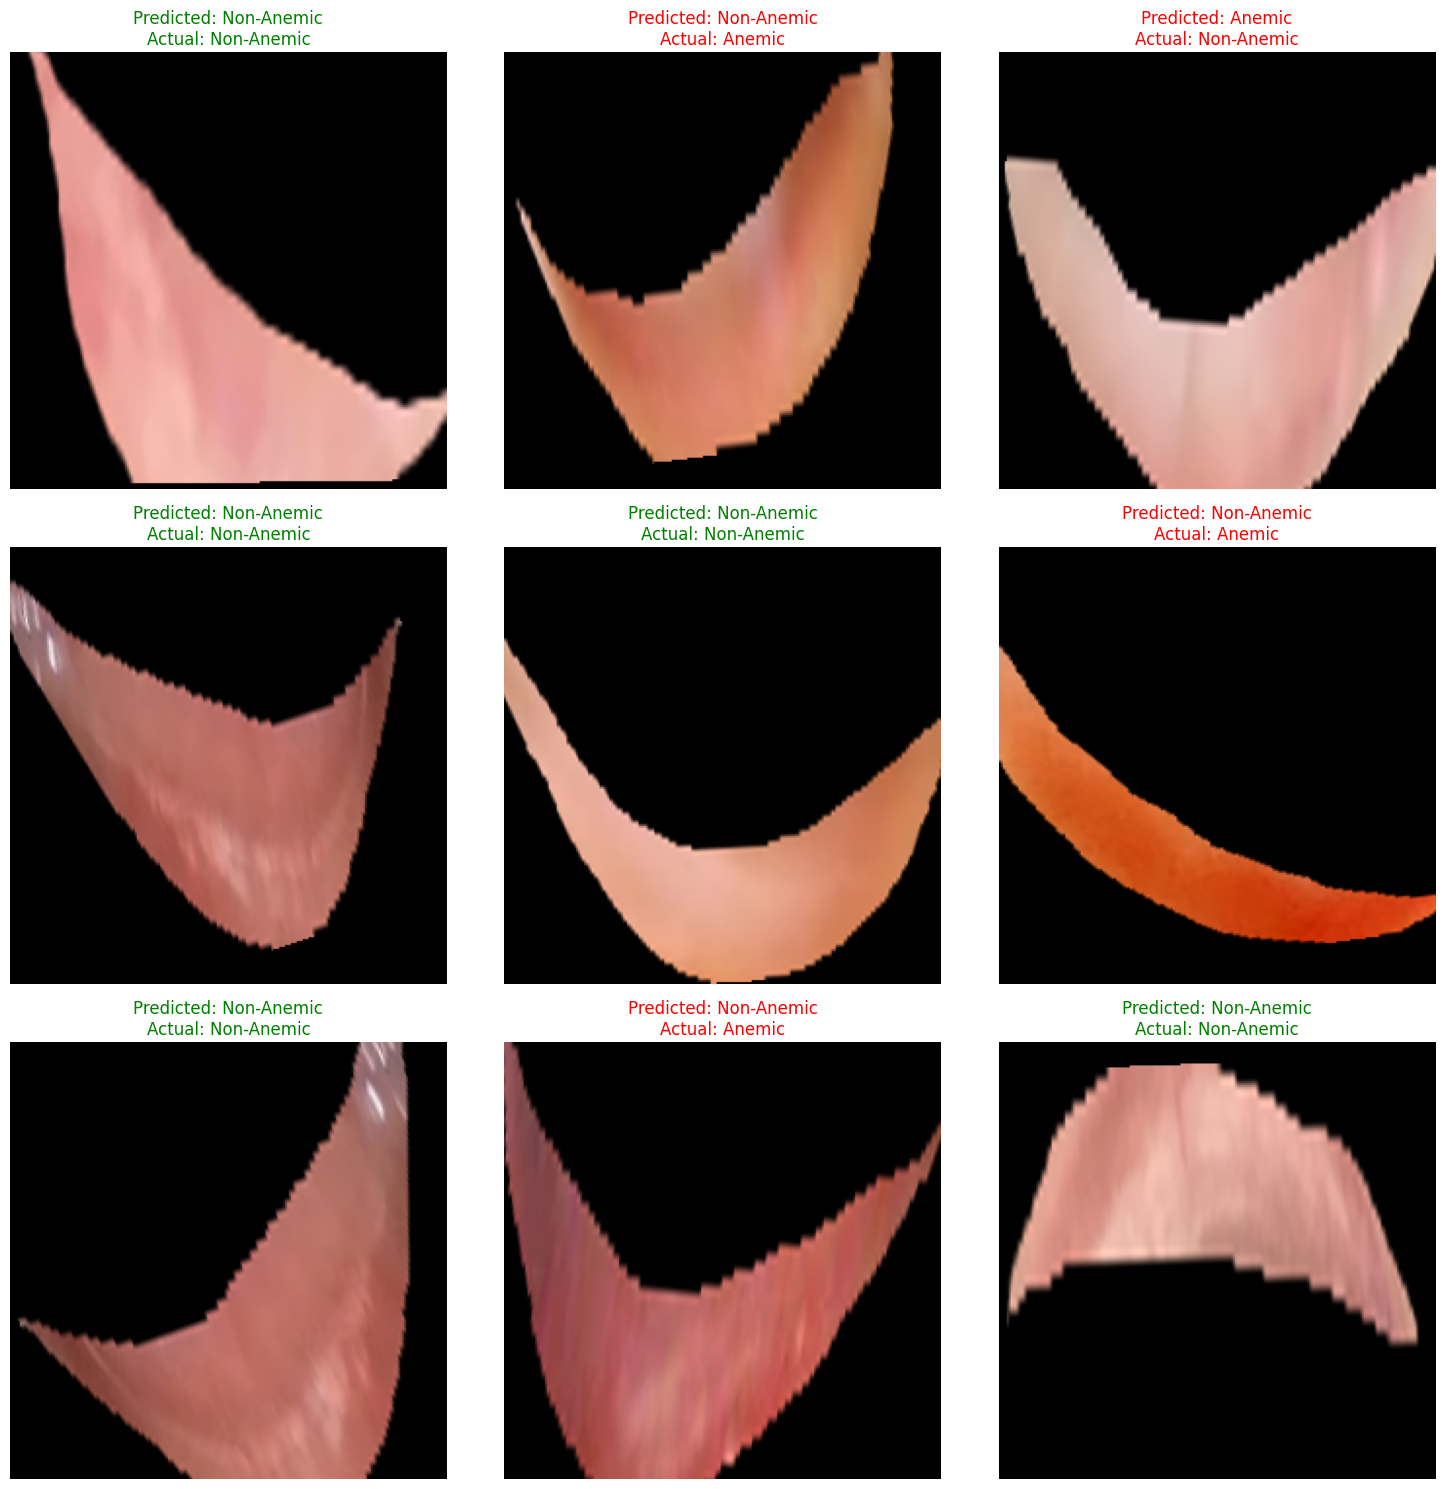

In [ ]:
test_dir = "/content/New_Augmented_Anemia_Dataset/Conjuctiva/Testing"
class_names = ["Anemic", "Non-Anemic"]
img_size = (224, 224)
model = load_model("/content/best_fine_tuned_model.keras")

# === HELPER ===
def load_and_preprocess_image(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, img_size)
    img = img / 255.0
    return np.expand_dims(img, axis=0), img

# === COLLECT SAMPLE IMAGES ===
image_paths = []
true_labels = []

for label in class_names:
    folder = os.path.join(test_dir, label)
    for fname in os.listdir(folder):
        if fname.lower().endswith((".jpg", ".jpeg", ".png")):
            image_paths.append(os.path.join(folder, fname))
            true_labels.append(label)

# === PREDICT & DISPLAY ===
plt.figure(figsize=(15, 15))

for i in range(9):  # show 9 samples
    img_path = image_paths[random.randint(0,len(image_paths) - 1)]
    true_label = true_labels[random.randint(0,len(true_labels) -1)]

    input_img, display_img = load_and_preprocess_image(img_path)
    prediction = model.predict(input_img)
    pred_class = class_names[np.argmax(prediction)]

    plt.subplot(3, 3, i+1)
    plt.imshow(display_img)
    plt.title(f"Predicted: {pred_class}\nActual: {true_label}", color="green" if pred_class == true_label else "red")
    plt.axis("off")

plt.tight_layout()
plt.show()